### 初始化环境

In [1]:
# 在jupyter notebook里env.render看不到窗口
# 写一个helper类，用matplotlib刷新显示图像
# 初始化传入env，调用helper的render即可
from IPython import display # 导入display模块，用于在Jupyter Notebook中显示图像
import matplotlib
import matplotlib.pyplot as plt # 导入matplotlib库，用于绘制图像
%matplotlib inline

class GymHelper:
    def __init__(self, env, figsize = (3, 3)):
        self.env = env # 初始化Gym环境
        self.figsize = figsize # 初始化绘图窗口大小
        
        plt.figure(figsize = figsize) # 创建绘图窗口
        plt.title(self.env.spec.id) # 标题设为环境名
        self.img = plt.imshow(env.render()) # 在绘图窗口中显示初始图像
    
    def render(self, title = None):
        image_data = self.env.render() # 获取当前环境图像渲染数据
        
        self.img.set_data(image_data) # 更新绘图窗口中的图像数据
        display.display(plt.gcf()) # 刷新显示
        display.clear_output(wait = True) # 有新图片时再清除绘图窗口原有图像
        if title: # 如果有标题，就显示标题
            plt.title(title)

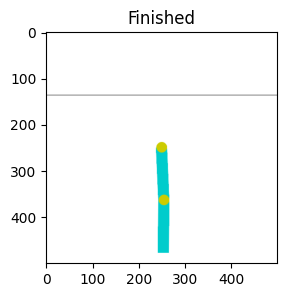

In [2]:
# 导入gym库
import gym

# 创建环境，指定渲染模式为rgb_array，如果是在IDE中可以改为'human'
env = gym.make('Acrobot-v1', render_mode='rgb_array')
# 重置环境
env.reset()
# 创建GymHelper
gym_helper = GymHelper(env)

# 循环N次
for i in range(20):
    gym_helper.render(title = str(i)) # 渲染环境
    action = env.action_space.sample() # 从动作空间中随机选取一个动作
    observation, reward, terminated, truncated, info = env.step(action) # 执行动作
    if terminated or truncated: # 如果游戏结束，则结束循环
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

环境介绍 https://www.gymlibrary.dev/environments/classic_control/acrobot/

### PPO

In [3]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import sys
import time
import random
import collections
from tqdm import * # 用于显示进度条

# 策略模型，给定状态生成各个动作的概率
class PolicyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyModel, self).__init__()
        
        # 使用全连接层构建一个简单的神经网络，ReLU作为激活函数
        # 最后加一个Softmax层，使得输出可以看作是概率分布
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim = 1)
        )

    # 定义前向传播，输出动作概率分布
    def forward(self, x):
        action_prob = self.fc(x)
        return action_prob

# 价值模型，给定状态估计价值
class ValueModel(nn.Module):
    def __init__(self, input_dim):
        super(ValueModel, self).__init__()
        
        # 网络结构和策略模型类似，但是输出层只有一个节点
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    # 定义前向传播，输出价值估计
    def forward(self, x):
        value = self.fc(x)
        return value

In [6]:
# 定义PPO类
class PPO:
    # 构造函数，参数包含环境，学习率，折扣因子，优势计算参数，clip参数，训练轮数
    def __init__(self, env, learning_rate=0.001, gamma=0.99, lamda=0.95, clip_eps=0.2, epochs=10):
        self.env = env
        self.gamma = gamma
        self.lamda = lamda
        self.clip_eps = clip_eps
        self.epochs = epochs

        # 判断可用的设备是 CPU 还是 GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 根据环境的观测空间和动作空间，定义策略模型和价值模型，并将模型移动到指定设备上
        self.policy_model = PolicyModel(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.value_model = ValueModel(env.observation_space.shape[0]).to(self.device)

        # 定义Adam优化器
        self.policy_optimizer = torch.optim.Adam(self.policy_model.parameters(), lr=learning_rate)
        self.value_optimizer = torch.optim.Adam(self.value_model.parameters(), lr=learning_rate)
    
    # 使用策略模型生成动作概率分布并采样
    def choose_action(self, state):
        # 将状态转换为tensor输入模型
        state = torch.FloatTensor(np.array([state])).to(self.device)
        with torch.no_grad():
            action_prob = self.policy_model(state)
        
        # 生成分布后采样返回动作
        c = torch.distributions.Categorical(action_prob)
        action = c.sample()
        return action.item()
    
    # 广义优势估计
    def calc_advantage(self, td_delta):
        # 将TD误差转换为numpy数组
        td_delta = td_delta.cpu().detach().numpy()
        # 初始化优势函数值及存储优势值的列表
        advantage = 0
        advantage_list = []
        # 反向遍历，从最后一步开始倒推
        for r in td_delta[::-1]:
            # 将当前步的TD误差及上一步优势加权值作为当前步的优势
            advantage = r + self.gamma * self.lamda * advantage
            # 将优势值加到列表开头，最终得到顺序序列
            advantage_list.insert(0, advantage)
        # 转换为tensor后返回
        return torch.FloatTensor(np.array(advantage_list)).to(self.device)
    
    # 模型更新
    def update(self, buffer):
        # 取出数据，并将其转换为numpy数组
        # 然后进一步转换为tensor，并将数据转移到指定计算资源设备上
        states, actions, rewards, next_states, dones = zip(*buffer)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        #actions = torch.tensor(np.array(actions)).view(-1, 1).to(self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.long).view(-1, 1).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).view(-1, 1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(np.array(dones)).view(-1, 1).to(self.device)

        with torch.no_grad():
            # 计算旧策略下的动作概率
            old_action_prob = torch.log(self.policy_model(states).gather(1, actions))
            
            # 计算TD目标及误差
            td_target = rewards + (1 - dones) * self.gamma * self.value_model(next_states)
            td_delta = td_target - self.value_model(states)
        
        # 优势估计
        advantage = self.calc_advantage(td_delta)
        
        # 多步更新策略
        for i in range(self.epochs):
            # 计算新策略下的动作概率
            action_prob = torch.log(self.policy_model(states).gather(1, actions))
            # 计算策略动作概率比
            ratio = torch.exp(action_prob - old_action_prob)
            
            # CLIP修剪
            part1 = ratio * advantage
            part2 = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantage
            # 计算策略损失
            policy_loss = -torch.min(part1, part2).mean()
            # 计算价值损失
            value_loss = F.mse_loss(self.value_model(states), td_target).mean()
            
            # 梯度清零、反向传播、更新参数
            self.policy_optimizer.zero_grad()
            self.value_optimizer.zero_grad()
            policy_loss.backward()
            value_loss.backward()
            self.policy_optimizer.step()
            self.value_optimizer.step()

In [7]:
# 定义超参数
max_episodes = 300 # 训练episode数
max_steps = 500 # 每个回合的最大步数

# 创建PPO对象
agent = PPO(env)
# 定义保存每个回合奖励的列表
episode_rewards = []

# 开始循环，tqdm用于显示进度条并评估任务时间开销
for episode in tqdm(range(max_episodes), file=sys.stdout):
    # 重置环境并获取初始状态
    state, _ = env.reset()
    # 当前回合的奖励
    episode_reward = 0
    # 记录每个episode的信息
    buffer = []

    # 循环进行每一步操作
    for step in range(max_steps):
        # 根据当前状态选择动作
        action = agent.choose_action(state)
        # 执行动作，获取新的信息
        next_state, reward, terminated, truncated, info = env.step(action)
        # 判断是否达到终止状态
        done = terminated or truncated
        
        # 将这个五元组加到buffer中
        buffer.append((state, action, reward, next_state, done))
        # 累计奖励
        episode_reward += reward
        
        # 更新当前状态
        state = next_state

        if done:
            break
    
    # 更新策略
    agent.update(buffer)
    # 记录当前回合奖励值
    episode_rewards.append(episode_reward)
    
    # 打印中间值
    if episode % (max_episodes // 10) == 0:
        tqdm.write("Episode " + str(episode) + ": " + str(episode_reward))

Episode 0: -500.0                                                                                                      
Episode 30: -500.0                                                                                                     
Episode 60: -293.0                                                                                                     
Episode 90: -134.0                                                                                                     
Episode 120: -65.0                                                                                                     
Episode 150: -81.0                                                                                                     
Episode 180: -90.0                                                                                                     
Episode 210: -79.0                                                                                                     
Episode 240: -78.0                      

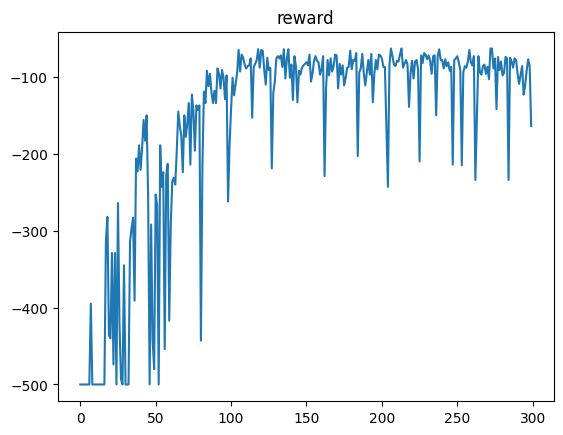

In [8]:
# 使用Matplotlib绘制奖励值的曲线图
plt.plot(episode_rewards)
plt.title("reward")
plt.show()

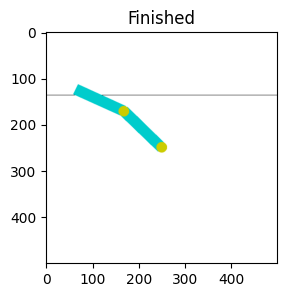

In [11]:
# 重置环境，开始新的一轮游戏
observation, _ = env.reset()
# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env, figsize = (3, 3))

# 开始游戏
for i in range(500):
    # 渲染环境，title为当前步骤数
    gym_helper.render(title = str(i))
    
    # 找到当前状态下的最优动作
    action = agent.choose_action(observation)
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)
    
    # 如果游戏结束，则结束当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()